## Библиотеки, параметры, константы задачи

In [4]:

!pip install -q polygenerator einops timm pytorch_wavelets PyWavelets tensorboard pytorch_msssim scipy matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import sys

PATH_BASE = "D:\\projects\\python\\DenoisingCNN"

sys.path.append(PATH_BASE)

from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
import numpy as np
from common.fstream import read_tensor, read_matrix, rescale_array, read_mc_tensor
from common.matrix import add_noise

NAME_DATASET = "gcg19"
env = PolyFeaturesEnv(name_model="k_1", 
                      name_dataset=NAME_DATASET, 
                      path_base=PATH_BASE,
                      device_name="cuda")


D:\projects\python\DenoisingCNN\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\projects\python\DenoisingCNN\venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Загрузка данных

In [3]:
import torchvision
from scipy import fftpack

def fft2d_transform(path):
    x = read_matrix(path)
    #x = torch.tensor(read_matrix(path), dtype=torch.float)
    # fft2 = torch.fft.fft2(x, norm="ortho")
    # res = torch.dstack([fft2.real, fft2.imag]).permute([2, 0, 1])
    # return res.detach().numpy()
    
    t =  np.log(fftpack.fftshift( fftpack.fft2(x) ))
    return t.real #np.dstack([t.real, t.imag])
# t =  np.log(fftpack.fftshift( fftpack.fft2(x)))

env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=4, val_batch_size=4
    ) \
    .load_feature(
        shape=(1, 80, 80), feature_name="Uvych2_noised_re.xls", mapper=fft2d_transform, transform=None, lazy_load=False
    ) \
    .set_target(
        shape=(1, 80, 80), target_name="Uvych2_re.xls", mapper=fft2d_transform, transform=None, lazy_load=False
    ) \

print(env.train_count, env.val_count)

223 16oading progress: |██████████████████████████████████████████████----| 93.8% Complete | 


In [ ]:
from scipy import fftpack

def get_noised(uvych, pct):
    uvych_noised = uvych.copy()
    for i in range(len(uvych)):
        for j in range(len(uvych[i])):
            ppp = np.random.uniform(low=0, high=pct)
            uvych_noised[i][j] *= (1 + ppp)
                    
    return uvych_noised

def f(x):
    return fftpack.fftshift(fftpack.fft2(x)) # np.log(fftpack.fft2(x))


def preprocess(path):
    data = read_matrix(path)
    step_pct = 0.001
    k = 5
    psd2D_noised = sum([f(get_noised(data, step_pct)) for _ in range(k)]) / k
    return np.stack([psd2D_noised.real, psd2D_noised.imag])

def preprocess2(path):
    data = read_matrix(path)
    psd2D = f(data)
    return np.stack([psd2D.real, psd2D.imag])
    
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=16, val_batch_size=4
    ) \
    .load_feature(
        shape=(2, 80, 80), feature_name="Uvych2_re.xls", mapper=preprocess, transform=None
    ) \
    .set_target(
        shape=(2, 80, 80), target_name="Uvych2_re.xls", mapper=preprocess, transform=None
    ) \

print(env.train_count, env.val_count)

In [9]:
env.train_count 

22

In [10]:
 len(env.train_target_loader)


227

In [3]:
from scipy import fftpack

def get_noised(uvych, pct):
    uvych_noised = uvych.copy()
    for i in range(len(uvych)):
        for j in range(len(uvych[i])):
            ppp = np.random.uniform(low=0, high=pct)
            uvych_noised[i][j] *= (1 + ppp)
                    
    return uvych_noised

def f(x):
    return fftpack.fftshift(fftpack.fft2(x)) # np.log(fftpack.fft2(x))


def preprocess(path):
    data = read_matrix(path)
    step_pct = 0.3
    k = 1
    psd2D_noised = sum([get_noised(data, step_pct) for _ in range(k)]) / k
    return psd2D_noised

def preprocess2(path):
    data = read_matrix(path)
    psd2D = f(data)
    return psd2D.imag.ravel()


def preprocess3(path):
    data = read_matrix(path + "_re.xls")
    data_noised = read_matrix(path + "_noised_re.xls")
    
    psd2D = f(data)
    psd2D_noised = f(data_noised)
    
    return (psd2D - psd2D_noised).imag.ravel()

def preprocess4(path):
    data_re = read_matrix(path + "_re.xls")
    data_im = read_matrix(path + "_im.xls")
    
    return np.concatenate([data_re, data_im]).ravel()
    
env.clear_features_and_targets()
env.set_batch_size(
        train_batch_size=32, val_batch_size=16
    ) \
    .load_feature(
        shape=(1, 64, 64,), feature_name="K_abs.xls", mapper=preprocess, transform=None, ignore_not_exists=True
    ) \
    .set_target(
        shape=(1, 64, 64,), target_name="K_abs.xls", mapper=read_matrix, transform=None, ignore_not_exists=True
    ) \

print(env.train_count, env.val_count)

113 62oading progress: |█████████████████████████████████████████████████-| 98.4% Complete | 


In [10]:
env.train_features_loaders[0].shape

(1, 64, 64)

In [24]:
dataset = {"train_input": env.train_features_loaders[0][0].cpu().detach().tolist(), 
           "train_label": env.train_target_loader[0][0].cpu().detach().tolist()}
import json
with open("dataset10-2.json", "w", encoding="utf8") as file:
    json.dump(dataset, file)

In [ ]:
from kan import KAN
model = KAN(width=[4096, 4096, 4096], grid=5, k=3, seed=0, device="cpu")


In [ ]:
model.train(dataset, opt="LBFGS", steps=3, lamb=0.01, lamb_entropy=10.);

In [ ]:
from kan import *
# формируем KAN: 2D входы, 1D выходы, 5 скрытых нейронов, 
# кубические сплайны и сетка на 5 точках.
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.);


In [ ]:
from scipy import fftpack

def get_noised(uvych, pct):
    uvych_noised = uvych.copy()
    for i in range(len(uvych)):
        for j in range(len(uvych[i])):
            ppp = np.random.uniform(low=0, high=pct)
            uvych_noised[i][j] *= (1 + ppp)
                    
    return uvych_noised

def f(x):
    return fftpack.fftshift(fftpack.fft2(x)) # np.log(fftpack.fft2(x))


def preprocess(path):
    data = read_matrix(path)
    step_pct = 0.001
    k = 1
    psd2D = f(data)
    psd2D_noised = sum([f(get_noised(data, step_pct)) for _ in range(k)]) / k
    return np.concatenate([(psd2D.real - psd2D_noised.real).ravel(), (psd2D.imag - psd2D_noised.imag).ravel()])

def preprocess2(path):
    data = read_matrix(path)
    psd2D = f(data)
    return np.concatenate([psd2D.real.ravel(), psd2D.imag.ravel()])
    
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=16, val_batch_size=4
    ) \
    .load_feature(
        shape=(2 * 80 * 80,), feature_name="Uvych2_re.xls", mapper=preprocess, transform=None
    ) \
    .set_target(
        shape=(2 * 80 * 80,), target_name="Uvych2_re.xls", mapper=preprocess, transform=None
    ) \

print(env.train_count, env.val_count)

In [2]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        shape=(1, 80, 80), feature_name="Uvych2_noised_re_rotated.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        shape=(1, 80, 80), target_name="Uvych2_re_rotated.xls", mapper=lambda path: read_matrix(path), transform=None
    ) \

print(env.train_count, env.val_count)

27 16loading progress: |██████████████████████████████████████████████----| 93.8% Complete | 


In [6]:
t = env.train_target_loader[10][3].max()
t

tensor(1.4297)

In [7]:
t = env.train_features_loaders[0][2].max()
t

tensor(4314.8682)

In [17]:
orig = torch.fft.ifft2(fft2, norm="ortho")

In [3]:
import matplotlib.pyplot as plt
im = plt.imshow(orig.imag.cpu().detach().numpy())
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)


NameError: name 'orig' is not defined

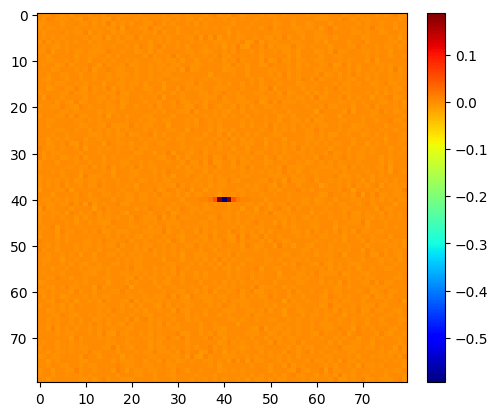

In [3]:
import matplotlib.pyplot as plt
im = plt.imshow(env.train_features_loaders[0][0][0][0].cpu().detach().numpy() - env.train_target_loader[0][0][0].cpu().detach().numpy(), cmap="jet")
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)


## Модели

### Новая локальная модель

In [29]:
env.set_name_model("uvych_matrix_noise_predictor_2")

In [3]:
env.model = models.autoencoders.UnetAutoencoder.UNetAuto(num_channels=1, num_out_channels=1).to(env.device)

In [26]:
env.model = models.autoencoders.unet.UNet(in_channels=1, out_channels=1, init_features=64).to(env.device)


In [14]:
env.model = models.autoencoders.purecnns.ConvAutoencoderLumaRelu9(in_channels=1, out_channels=1).to(env.device)


In [3]:
env.model = models.autoencoders.res_unet.ResUnetPlusPlus(channel=1).to(env.device)

In [4]:
env.model = models.autoencoders.residual.AEv6_0(in_channels=1, out_channels=1).to(env.device)
# fm_path="/home/amedvedev/projects/python/DenoisingCNN/assets/pt/uvych_matrix_denoiser_10 (4th copy).pt"
# from torch import nn


In [3]:
env.model = models.autoencoders.residual.AEv8(in_channels=1, out_channels=1, inner_channels=64, num_blocks=2).to(env.device)
_x = torch.randn(4, 1, 64, 64, device=env.device)
print(env.model(_x).size())

print("params", sum(p.numel() for p in env.model.parameters() if p.requires_grad))

torch.Size([4, 1, 64, 64])
params 659074


In [70]:
from torch import nn
class AEv9(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AEv9, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.prev = torch.load("../../assets/pt/k_1.pt")

        self.current = models.autoencoders.residual.AEv6_0(2, out_channels)

        self.prev.requires_grad_(False)

    def forward(self, x):
        step = torch.stack([x, self.prev(x)], axis=2).squeeze()
        res = self.current(step)
        return res
        
env.model =AEv9(in_channels=1, out_channels=1).to(env.device)
_x = torch.randn(4, 1, 64, 64, device=env.device)
print(env.model(_x).size())

print("params", sum(p.numel() for p in env.model.parameters() if p.requires_grad))

torch.Size([4, 1, 64, 64])
params 514641


C:\Users\webfo\AppData\Local\Temp\ipykernel_13776\3812448168.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.prev = torch.load("../../assets/pt/k_1.pt")


In [84]:
from transformers import AutoModel

In [87]:
!pip install mambavision


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [20 lines of output]
  Traceback (most recent call last):
    File "C:\Users\webfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\webfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\webfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
      return hook(config_settings)
             ^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\webfo\AppData\Local\Temp\pip-build-env-q95nihr2\overlay\Lib\site-packages\setuptools\build_me

In [85]:
model = AutoModel.from_pretrained("nvidia/MambaVision-T-1K", trust_remote_code=True)


config.json:   0%|          | 0.00/36.4k [00:00<?, ?B/s]

C:\Users\webfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\webfo\.cache\huggingface\hub\models--nvidia--MambaVision-T-1K. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py:   0%|          | 0.00/27.9k [00:00<?, ?B/s]

Encountered exception while importing mamba_ssm: No module named 'mamba_ssm'


ImportError: This modeling file requires the following packages that were not found in your environment: mamba_ssm. Run `pip install mamba_ssm`

In [49]:
from torch import nn
class AEv10(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AEv10, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.prev = torch.load("../../assets/pt/k_1.pt")

        self.current = torch.load("../../assets/pt/k_1.pt") # models.autoencoders.residual.AEv6_0(1, out_channels)

        self.prev.requires_grad_(False)

    def forward(self, x):
        res = (self.prev(x) + self.current(x)) / 2.0
        return res
        
env.model =AEv10(in_channels=1, out_channels=1).to(env.device)
_x = torch.randn(4, 1, 64, 64, device=env.device)
print(env.model(_x).size())

print("params", sum(p.numel() for p in env.model.parameters() if p.requires_grad))

C:\Users\webfo\AppData\Local\Temp\ipykernel_13776\2204610263.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.prev = torch.load("../../assets/pt/k_1.pt")
C:\Users\we

torch.Size([4, 1, 64, 64])
params 514321


In [16]:
import os
os.listdir('../')

['denoise',
 'denoiser_environment.ipynb',
 'embeddings',
 'image_denoising.ipynb',
 'matrix_denoising.ipynb',
 'predict',
 'reconstruct',
 'reconstruct.ipynb',
 'transform_environment.ipynb',
 '__init__.py']

In [6]:
m = torch.load("../../assets/pt/k_1.pt").eval()

C:\Users\webfo\AppData\Local\Temp\ipykernel_4656\2750138303.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load("../../assets/pt/k_1.pt").eval()


In [4]:
env.model = models.predictors.NoiseMatrixPredictor_v1(1, 1, 80, 80, 80 * 80).to(env.device)

In [13]:
env.model = models.autoencoders.wavelet.WMDCNN(1, 4, 4, 28).to(env.device)

In [3]:
from torch import nn
class UvychDimExpand(nn.Module):
    def __init__(self, size, hidden_sizes):
        super(UvychDimExpand, self).__init__()
        
        self.size = size
        self.hidden_sizes = hidden_sizes

        self.layers = nn.ModuleList(
            [
                nn.Linear(size, hidden_sizes[0]),
                nn.LeakyReLU()
            ]
            +
            [
                nn.Sequential(
                    nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]),
                    nn.LeakyReLU()

                )
                for i in range(1, len(hidden_sizes))
            ]
            +
            [
                nn.Linear(hidden_sizes[-1], size)
            ]
        )


    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x



In [11]:
from models.kan import KAN
env.model = KAN([64 * 64 * 2, 64 * 64 * 2, 64, 64 * 64 * 2]).to(env.device)
env.model

KAN(
  (layers): ModuleList(
    (0-2): 3 x KANLinear(
      (base_activation): SiLU()
    )
  )
)

In [4]:
env.model = UvychDimExpand(2 * 80 * 80, [2 * 80 * 80, 2 * 80 * 80]).to(env.device)
env.model 


UvychDimExpand(
  (layers): ModuleList(
    (0): Linear(in_features=12800, out_features=12800, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Sequential(
      (0): Linear(in_features=12800, out_features=12800, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Linear(in_features=12800, out_features=12800, bias=True)
  )
)

In [44]:
env.model = UvychDimExpand(64 * 64, [80 * 80, 64 * 64]).to(env.device)
env.model 


UvychDimExpand(
  (layers): ModuleList(
    (0): Linear(in_features=4096, out_features=6400, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Sequential(
      (0): Linear(in_features=6400, out_features=4096, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Linear(in_features=4096, out_features=4096, bias=True)
  )
)

In [72]:
from torch import nn
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight.data)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        # nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias.data, 0)

env.model.current.apply(weights_init)

AEv6_0(
  (conv0): Conv2d(2, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_transpose0): ConvTranspose2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_transpose1): ConvTranspose2d(80, 80, kern

In [22]:
env.model = models.autoencoders.swin_unet.SwinTransformerSys(64, in_chans=1, num_classes=1, window_size=4).to(env.device)


SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


In [4]:
env.model

AEv4_0(
  (first): AEv2_0(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose3): ConvTranspose2d(64, 64, k

### Импорт претренерованной модели

In [ ]:
env.model()

In [7]:
env.load_model(model_type="pt")

D:\projects\python\DenoisingCNN\applications\abstract_environment.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(self.path_save_model(model_typ

In [9]:
env.model

AEv6_0(
  (conv0): Conv2d(1, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_transpose0): ConvTranspose2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_transpose1): ConvTranspose2d(80, 80, kern

## Визуализация батча валидационного датасета

In [11]:
np.random.random_integers(low=3, high = 64 - 3, size=2)

C:\Users\webfo\AppData\Local\Temp\ipykernel_4656\4222949343.py:1: DeprecationWarning: This function is deprecated. Please call randint(3, 61 + 1) instead
  np.random.random_integers(low=3, high = 64 - 3, size=2)


array([37, 19], dtype=int32)

C:\Users\webfo\AppData\Local\Temp\ipykernel_4656\313271410.py:5: DeprecationWarning: This function is deprecated. Please call randint(20, 44 + 1) instead
  x, y = np.random.random_integers(low=rad, high = 64 - rad, size=2).tolist()


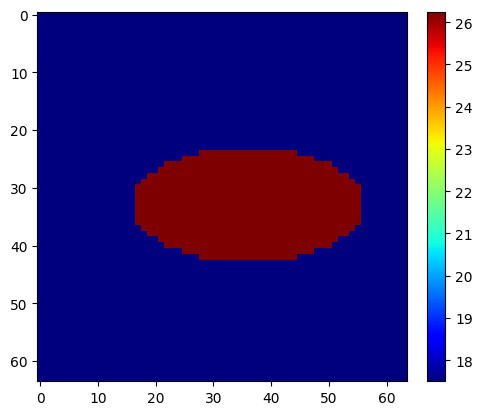

In [22]:
def gen_test_circle_matrix() -> np.ndarray:
    result = np.full((64, 64), 17.5)
    rad = 20
    for p in range(1):
        x, y = np.random.random_integers(low=rad, high = 64 - rad, size=2).tolist()
        for i in range(64):
            for j in range(64):
                if (4 * (x - i) ** 2 + (y - j) ** 2) ** 0.5 < rad:
                    result[i][j] = result[i][j] * 1.5
    import matplotlib.pyplot as plt
    im = plt.imshow(result, cmap='jet')
    plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
    return result   
    
real_matrix = gen_test_circle_matrix()

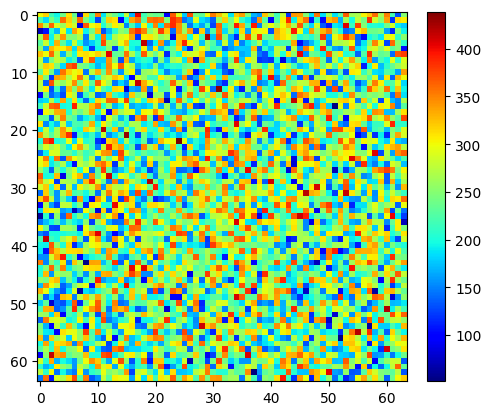

In [63]:
from common.matrix import add_noise
noised_matrix  = add_noise(real_matrix, 1, 1.)
import matplotlib.pyplot as plt
im = plt.imshow(noised_matrix, cmap='jet')
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)

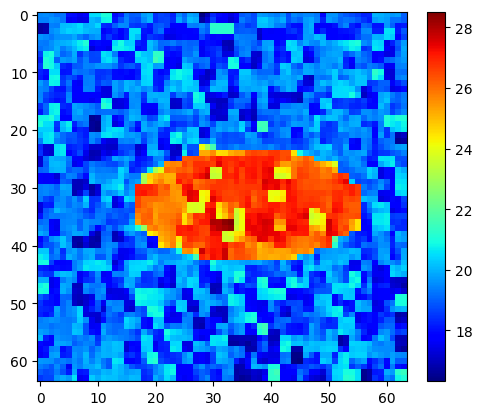

In [57]:
restored_matrix = env.model(torch.from_numpy(noised_matrix).view(1, 1, 64, 64).to(env.device, dtype=torch.float)).detach().cpu().numpy()
import matplotlib.pyplot as plt
im = plt.imshow(restored_matrix.reshape(64, 64), cmap='jet')
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)

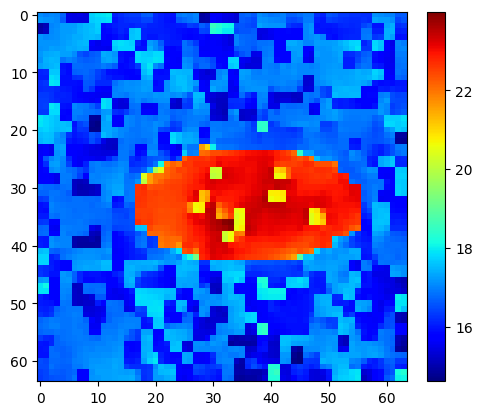

In [58]:
restored_matrix = env.model(torch.from_numpy(restored_matrix.reshape(64, 64)).view(1, 1, 64, 64).to(env.device, dtype=torch.float)).detach().cpu().numpy()
import matplotlib.pyplot as plt
im = plt.imshow(restored_matrix.reshape(64, 64), cmap='jet')
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)

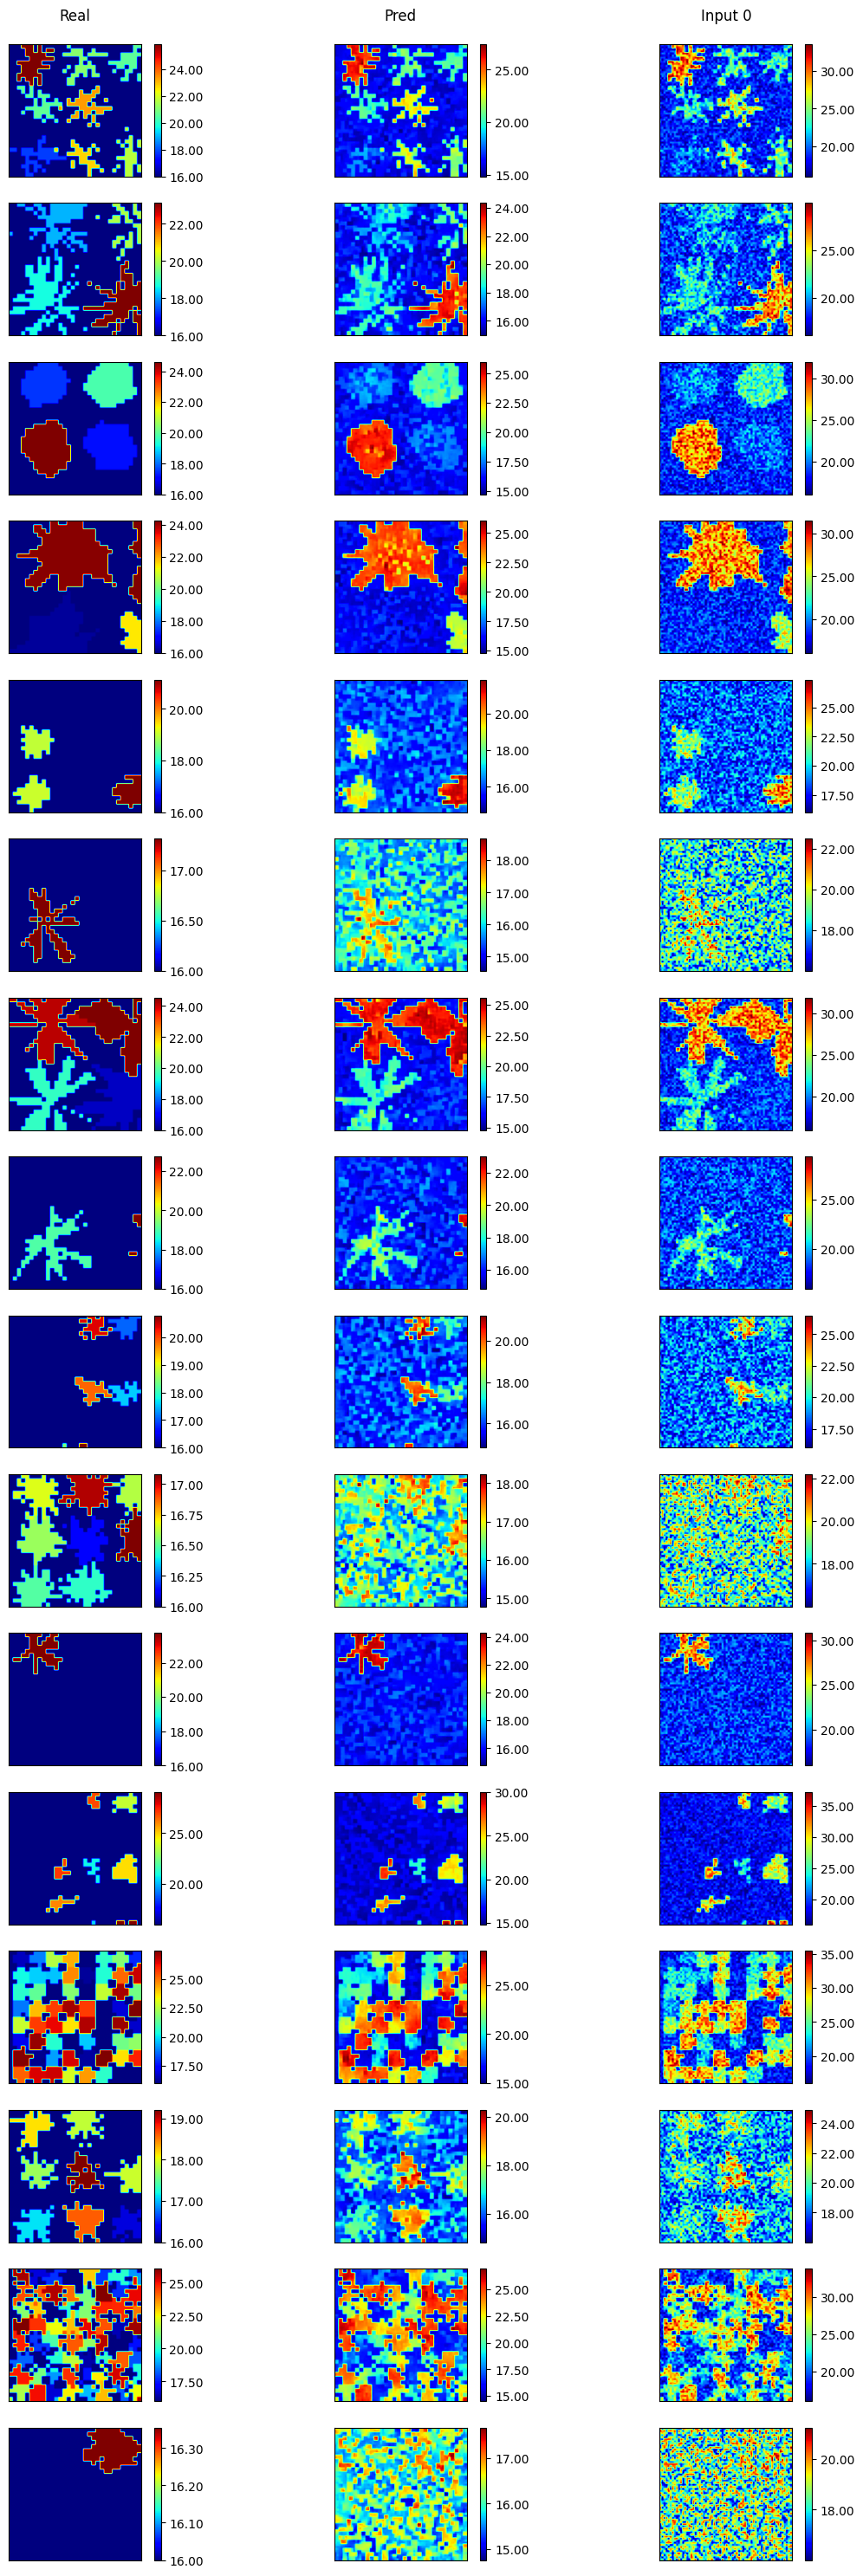

In [7]:
env.plot_batch_with_inputs(concrete=1, figsize=(12, 30), format="%.2f", wspace=0.0, hspace=0.2)


In [15]:
env.val_target_loader[3][0].shape

torch.Size([12800])

In [ ]:
env.plot_batch(concrete=1, figsize=(10, 10), format="%.4f", wspace=0.0, hspace=0.2, size=[64 * 64 * 2],
               func_postprocess=lambda x: x.reshape(64, 64 * 2))


In [42]:
env.model

AEv10(
  (prev): AEv6_0(
    (conv0): Conv2d(1, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv7): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv8): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv9): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv10): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv_transpose0): ConvTranspose2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (con

## Численные значения отклонений

In [58]:
def test():
    losses = []
    errors = []
    init_errors = []
    losses_dataset = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            outputs = env.model(*data_features) #* 65.

        
            
            for ex_id in range(env.val_batch_size):

                losses_dataset_step = torch.max(torch.abs(data_features[0][ex_id] - data_target[ex_id])).detach().tolist()
                losses_dataset.append(losses_dataset_step)
                
                init_error = torch.mean(torch.abs(data_features[0][ex_id] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
                init_errors.append(init_error.detach().tolist())

                loss = torch.max(torch.abs(outputs[ex_id] - data_target[ex_id]))
                losses.append(loss.detach().tolist())
                # print(data_target[ex_id].size())


                error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
                errors.append(error.detach().tolist())
                
    print("Начальное среднее отклонение по значениям:", sum(losses_dataset) / len(losses_dataset))
    print("Текущее среднее отклонение по значениям:", sum(losses) / len(losses))
    
    print()
    print("Начальное максимальное отклонение по значениям:", max(losses_dataset))
    print("Текущее максимальное отклонение по значениям в векторе:", max(losses))
    
    # print()
    print("Начальная средняя относительная ошибка:", sum(init_errors) / len(init_errors))
    print("Текущая средняя относительная ошибка:", sum(errors) / len(errors))
    # print()
    # print("Начальная максимальная относительная ошибка:", max(init_errors))
    # print("Текущая максимальная относительная ошибка:", max(errors))
test()

Начальное среднее отклонение по значениям: 6.40489560750223
Текущее среднее отклонение по значениям: 2.0484622466948723

Начальное максимальное отклонение по значениям: 8.967458724975586
Текущее максимальное отклонение по значениям в векторе: 4.361822128295898
Начальная средняя относительная ошибка: 0.15005100844427943
Текущая средняя относительная ошибка: 0.009246259685530658


## Training

In [74]:
from common.losses import MseCoeffLoss, L1CoeffLoss
from pytorch_msssim import MS_SSIM as _MS_SSIM


In [24]:
env.set_name_model("uvych_tensor_denoiser_2")

In [75]:
opt = torch.optim.AdamW(env.model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[int(10 * 0.6), int(10 * 0.9)], gamma=0.1)

In [76]:
class L1_MSSSIM(torch.nn.Module):
    def __init__(self):
        super(L1_MSSSIM, self).__init__()
        self.l1 = nn.L1Loss()
        self.ms_ssim = _MS_SSIM(data_range=4, size_average=True, win_size=1, channel=1)

    def forward(self, x, y):
        ms_ssim_loss = 1 - self.ms_ssim(x, y)
        l1_loss = self.l1(x, y)

        return l1_loss + ms_ssim_loss

In [29]:
from torch import nn

In [81]:
env.train(6, step_saving=True, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=L1_MSSSIM().to(env.device), 
          callbacks=[lambda: scheduler.step()]) #


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.173583335 	Validating Loss: 0.173399929 	Time: 4.90 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.173224503 	Validating Loss: 0.173055217 	Time: 4.88 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.172867010 	Validating Loss: 0.172763997 	Time: 4.86 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 

KeyboardInterrupt: 

In [61]:
opt = torch.optim.Adam(env.model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)



In [19]:
import gc
gc.collect()

0

In [62]:
env.train(3, step_saving=True, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=torch.nn.L1Loss(),
          callbacks=[lambda: scheduler.step(env.test_losses[-1])]) #lambda: scheduler.step(env.test_losses[-1])

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.280187875 	Validating Loss: 0.217931239 	Time: 4.79 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.214825575 	Validating Loss: 0.204036135 	Time: 4.86 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.193518488 	Validating Loss: 0.179139461 	Time: 5.17 m




## Сохранение модели

In [41]:
env.save(onnx=False, pth=False)

In [ ]:
from common.fstream import (create_dir_of_file_if_not_exists, create_dir_if_not_exists)
from applications import model_manager
path_save_model_onnx = env.path_save_model("onnx")
inp = torch.randn((1, 1, 64, 64), device=env.device)
create_dir_of_file_if_not_exists(path_save_model_onnx)
model_manager.save_onnx_model(env.model, path_save_model_onnx, inp)

## Loss visualisation

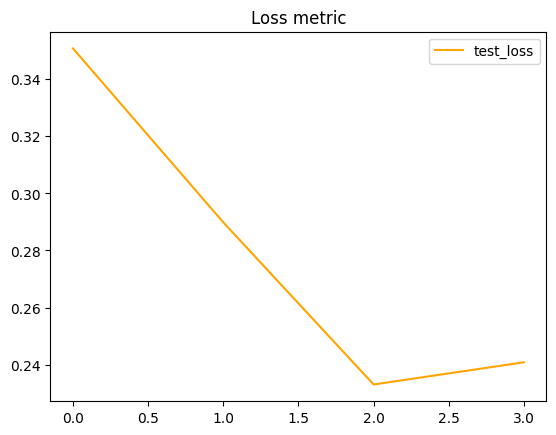

In [79]:
env.show_metrics(n_last=4, train=False, val=True)

## Clear memory

In [14]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()

In [13]:
env.model.cpu()
del env.model
import torch
torch.cuda.empty_cache()

In [6]:
def test():
    losses = []
    errors = []
    init_errors = []
    losses_dataset = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            
            x = data_features[0][0]
            
            fft2 = torch.fft.fft2(x, norm="ortho")

            x_fft = torch.dstack([fft2.real, fft2.imag]).view(80, 80, 2).permute([2, 0, 1])
            
            outputs_fft = env.model(x_fft) #* 65.
            
            outputs_fft_complex = torch.complex(*outputs_fft)
            
            fft2_inv = torch.fft.ifft2(outputs_fft_complex, norm="ortho")
            outputs = fft2_inv.real
            ex_id = 0
            data_target = data_target[0]
            
            losses_dataset_step = torch.max(torch.abs(data_features[0][ex_id][0] - data_target[ex_id])).detach().tolist()
            losses_dataset.append(losses_dataset_step)
            
            init_error = torch.mean(torch.abs(data_features[0][ex_id][0] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
            init_errors.append(init_error.detach().tolist())
            
            loss = torch.max(torch.abs(outputs - data_target[ex_id]))
            losses.append(loss.detach().tolist())
            # print(data_target[ex_id].size())
            
            
            error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
            errors.append(error.detach().tolist())
            
            # for ex_id in range(env.val_batch_size):
            #     
            #     losses_dataset_step = torch.max(torch.abs(data_features[0][ex_id][0] - data_target[ex_id])).detach().tolist()
            #     losses_dataset.append(losses_dataset_step)
            #     
            #     init_error = torch.mean(torch.abs(data_features[0][ex_id][0] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
            #     init_errors.append(init_error.detach().tolist())
            #     
            #     loss = torch.max(torch.abs(outputs[ex_id] - data_target[ex_id]))
            #     losses.append(loss.detach().tolist())
            #     # print(data_target[ex_id].size())
            #     
            #     
            #     error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
            #     errors.append(error.detach().tolist())
                #print(outputs, data_target)
                
    print("Начальное среднее отклонение по значениям:", sum(losses_dataset) / len(losses_dataset))
    print("Текущее среднее отклонение по значениям:", sum(losses) / len(losses))
    
    print()
    print("Начальное максимальное отклонение по значениям:", max(losses_dataset))
    print("Текущее максимальное отклонение по значениям в векторе:", max(losses))
    
    print()
    print("Начальная средняя относительная ошибка:", sum(init_errors) / len(init_errors))
    print("Текущая средняя относительная ошибка:", sum(errors) / len(errors))
    print()
    print("Начальная максимальная относительная ошибка:", max(init_errors))
    print("Текущая максимальная относительная ошибка:", max(errors))
test()

Начальное среднее отклонение по значениям: 0.026016585528850555
Текущее среднее отклонение по значениям: 2.1138689294457436

Начальное максимальное отклонение по значениям: 0.045397281646728516
Текущее максимальное отклонение по значениям в векторе: 4.617318630218506

Начальная средняя относительная ошибка: 0.005001195095246658
Текущая средняя относительная ошибка: 1.8679515551775694

Начальная максимальная относительная ошибка: 0.005064061377197504
Текущая максимальная относительная ошибка: 7.108710765838623
